In [1]:
import subprocess
import pandas as pd
import re
import os
import matplotlib.pyplot as plt

plt.rc('font', family='serif')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Command line commits to extract log information of commits

```
export LC_ALL=C

git log -p --reverse --diff-filter=ACM --pretty=format:"*@*@*%n%H%n%aN%n%aE%n%ad%n%s%n%d" --full-diff | \
    gawk 'match($0,"^@@ -([0-9]+),[0-9]+ [+]([0-9]+),[0-9]+ @@",a){left=a[1];right=a[2];next};\
   /^(---|\+\+\+|[^-+ ])/{print;next};\
   {line=substr($0,2)};\
   /^-/{print "-" left++ ":" line;next};\
   /^[+]/{print "+" right++ ":" line;next};\
   {print "(" left++ "," right++ "):"line}' > commits.log
```

In [9]:
vol = 'skywalking/'
# os.mkdir(vol)

In [10]:
with open('/Users/stock/Development/cs/cs515/' + vol + 'commits.log', 'r', errors='ignore') as f:
    
    def add_line():
        if (addition or subtraction) and file:
            commits = {'commit': commit, 'name': name, 'email': email,
                       'date': date, 'msg': msg, 'addition': addition,
                       'subtraction': subtraction, 'file': file }  
            l_commits.append(commits)
    
    l_commits, addition, subtraction = [], [], []
    valid = False
    line = f.readline().rstrip('\n')
    
    while line:
        
        if re.match('\+?\d+', line) and file:
            #+16:public static void main... extract 16
            addition.append(int(line[1:].partition(':')[0]))
            
        elif re.match('\-?\d+', line) and file:
            subtraction.append(int(line[1:].partition(':')[0]))
            
        elif 'diff --git' in line:
            add_line()
            addition = []
            subtraction = []
            file = ''
            if 'test' not in line and '.java' in line:
                file = line.split()[-1][2:]
            
        elif '*@*@*' in line:
            add_line()

            addition = []
            subtraction = []  
            file   = ''
            commit = f.readline().rstrip('\n')
            name   = f.readline().rstrip('\n')
            email  = f.readline().rstrip('\n')
            date   = f.readline().rstrip('\n')
            msg    = f.readline().rstrip('\n')
                            
        line = f.readline().rstrip('\n')
        
data = pd.DataFrame.from_dict(l_commits)
data.to_csv(vol + 'commits.csv', index=False)

In [11]:
data.tail()

,commit,name,email,date,msg,addition,subtraction,file
28993,00e8f2d88698a56b17023150b4e490d7d2376ee8,kezhenxu94,kezhenxu94@apache.org,Sun Apr 12 20:48:44 2020 +0800,Fix bug that the agent heart beats too frequen...,"[54, 88, 89, 94, 105, 112]","[54, 88, 89, 94, 105, 112]",apm-sniffer/apm-agent-core/src/main/java/org/a...
28994,171620bfa8e74bfc84e7d322c260f319943b7191,mrproliu,741550557@qq.com,Tue Apr 14 09:32:54 2020 +0800,Add Nginx correlation e2e test (#4646),"[111, 112, 113, 114]","[111, 112, 113]",apm-sniffer/apm-agent-core/src/main/java/org/a...
28995,12703fa54edeb55a6f92d123f767461ea62d1df0,Gao Hongtao,hanahmily@gmail.com,Wed Apr 15 15:08:38 2020 +0800,Keep latest index always present. (#4655),"[57, 62, 63, 69, 70, 71, 72]","[63, 64, 65, 66, 67]",oap-server/server-storage-plugin/storage-elast...
28996,c11ad038cceb0cb550dbec304b8f92db733eb0d0,kezhenxu94,kezhenxu94@apache.org,Wed Apr 15 23:09:05 2020 +0800,Count the coverage in E2E tests and Plugin tes...,[29],[29],oap-server/server-core/src/main/java/org/apach...
28997,c11ad038cceb0cb550dbec304b8f92db733eb0d0,kezhenxu94,kezhenxu94@apache.org,Wed Apr 15 23:09:05 2020 +0800,Count the coverage in E2E tests and Plugin tes...,[26],[26],oap-server/server-query-plugin/query-graphql-p...


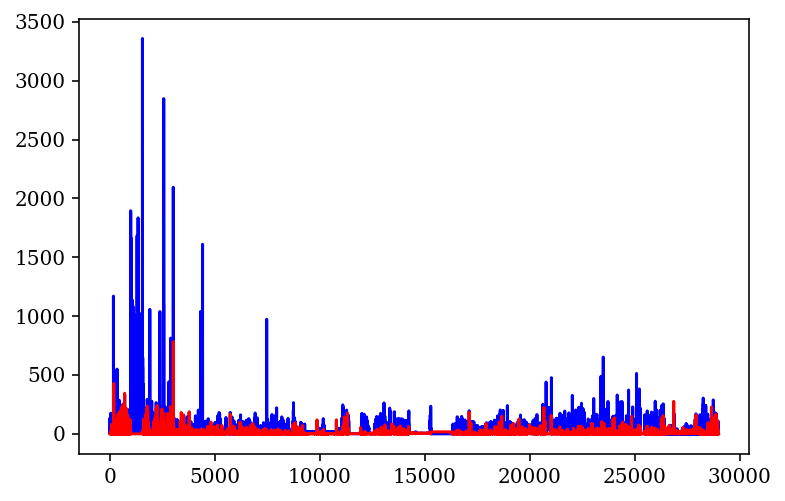

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

max_inserts = 5000

sample = data[(data['addition'].map(len) <= max_inserts) & 
              ((data['subtraction'].map(len) <= max_inserts))].reset_index(drop=True)
adds = sample.addition.map(lambda x: len(x))
subs = sample.subtraction.map(lambda x: len(x))

ax.plot(adds,'b')
ax.plot(subs,'r')

plt.show()

In [13]:
def print_progress_bar(iteration, total, prefix = '', suffix = '', decimals = 1,
                       length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    if iteration == total:
        print()

In [14]:
s = data[data['commit'] == 'fd3dc3a914332adf856b017550407c02358c0b60']
i = 2642
commit = data.iloc[i].commit
file = data.iloc[i].file
print(f'git show {commit}:{file}')

git show 9c23c745c76157ff32ce4c00af0556ba45aaa652:skywalking-collector/skywalking-protocol/src/main/java/com/ai/cloud/skywalking/protocol/AckSpan.java


# Run PMD and save output

In [15]:
dirr = '/Users/stock/Development/cs/cs515/project/'
temp = dirr + vol + 'temp'

total = len(data)
for i, row in data.iterrows():
    
    commit = row.commit
    file = row.file

    output = f'{temp}/{commit}/{file}'
    os.makedirs(os.path.dirname(output), exist_ok=True)
    
    show = f'git show {commit}:{file}'
    with open(output, 'w') as f:
        process = subprocess.Popen(show.split(), cwd='/Users/stock/Development/cs/cs515/' + vol, stdout=f)
        
    print_progress_bar(i + 1, total, prefix='Progress:', suffix='Complete', length=50)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [18]:
pmd = '/Users/stock/Development/cs/cs515/A4/pmd-bin-6.22.0/bin/run.sh pmd'
output = dirr + vol + 'pmd-results.csv'
cmd = f'{pmd} -d {temp} -R rulesets/java/quickstart.xml -f csv -r ' + output + ' -language java -version 1.8'

In [9]:
with open(output, 'w') as f:
    process = subprocess.Popen(cmd.split(), stdout=f)
    process.wait()
    
print('Done!')

Done!


In [20]:
smells = pd.read_csv(output)
smells.head()

,Problem,Package,File,Priority,Line,Description,Rule set,Rule
0,1,com.a.eye.skywalking.trace.tag,/Users/stock/Development/cs/cs515/project/temp...,1,9,The utility class name 'Tags' doesn't match '[...,Code Style,ClassNamingConventions
1,1,org.apache.skywalking.apm.agent.core.conf,/Users/stock/Development/cs/cs515/project/temp...,1,37,The utility class name 'Agent' doesn't match '...,Code Style,ClassNamingConventions
2,2,org.apache.skywalking.apm.agent.core.conf,/Users/stock/Development/cs/cs515/project/temp...,1,123,The utility class name 'Collector' doesn't mat...,Code Style,ClassNamingConventions
3,3,org.apache.skywalking.apm.agent.core.conf,/Users/stock/Development/cs/cs515/project/temp...,1,142,The utility class name 'Jvm' doesn't match '[A...,Code Style,ClassNamingConventions
4,4,org.apache.skywalking.apm.agent.core.conf,/Users/stock/Development/cs/cs515/project/temp...,1,149,The utility class name 'Buffer' doesn't match ...,Code Style,ClassNamingConventions


# Join smells to commits

In [ ]:
l_smells = []
for i, d_row in data.iterrows():
    commit = d_row.commit
    file = d_row.file
    
    smells_dict = []
    
    s = smells[(smells['File'].str.contains(commit, case=False, regex=False)) & (smells['File'].str.contains(file, case=False, regex=False))]
    for j, smell in s.iterrows():
        if smell.Line in d_row.addition:
            smells_dict.append({'line': smell.Line, 
                                'priority': smell.Priority, 
                                'rule': smell.Rule})
    
    l_smells.append(smells_dict)
    print_progress_bar(i + 1, total, prefix='Progress:', suffix='Complete', length=50)

In [ ]:
new_data = data.assign(smells=pd.Series(l_smells).values)
new_data.to_csv(vol + '/commits-smells.csv', index=False)
new_data.tail(100)

# Smell analysis

In [139]:
smelly_data = new_data[new_data['smells'].map(len) > 0].reset_index(drop=True)
smelly_data.tail()

,commit,name,email,date,msg,addition,subtraction,file,smells
5099,6fe2041b470113e626cb3f41e3789261d31f2548,吴晟 Wu Sheng,wu.sheng@foxmail.com,Fri Apr 10 11:03:24 2020 +0800,Make 8.0.0 Core available. New protocol and re...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",[],oap-server/server-receiver-plugin/skywalking-t...,"[{'line': 86, 'priority': 3, 'rule': 'Uncommen..."
5100,6fe2041b470113e626cb3f41e3789261d31f2548,吴晟 Wu Sheng,wu.sheng@foxmail.com,Fri Apr 10 11:03:24 2020 +0800,Make 8.0.0 Core available. New protocol and re...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",[],oap-server/server-receiver-plugin/skywalking-t...,"[{'line': 40, 'priority': 3, 'rule': 'MissingS..."
5101,6fe2041b470113e626cb3f41e3789261d31f2548,吴晟 Wu Sheng,wu.sheng@foxmail.com,Fri Apr 10 11:03:24 2020 +0800,Make 8.0.0 Core available. New protocol and re...,"[27, 28, 29, 53, 60, 66, 67, 71, 76, 82, 83, 9...","[27, 30, 31, 32, 54, 61, 67, 68, 72, 77, 83, 8...",oap-server/server-storage-plugin/storage-influ...,"[{'line': 91, 'priority': 3, 'rule': 'UnusedFo..."
5102,6fe2041b470113e626cb3f41e3789261d31f2548,吴晟 Wu Sheng,wu.sheng@foxmail.com,Fri Apr 10 11:03:24 2020 +0800,Make 8.0.0 Core available. New protocol and re...,"[21, 89, 90, 91, 123, 124, 125, 133, 134, 135,...","[30, 31, 90, 91, 123, 131, 163, 168, 191, 197]",oap-server/server-storage-plugin/storage-jdbc-...,"[{'line': 90, 'priority': 3, 'rule': 'Optimiza..."
5103,00e8f2d88698a56b17023150b4e490d7d2376ee8,kezhenxu94,kezhenxu94@apache.org,Sun Apr 12 20:48:44 2020 +0800,Fix bug that the agent heart beats too frequen...,"[54, 88, 89, 94, 105, 112]","[54, 88, 89, 94, 105, 112]",apm-sniffer/apm-agent-core/src/main/java/org/a...,"[{'line': 54, 'priority': 2, 'rule': 'AvoidUsi..."


In [160]:
i = 5015
smelly_data.iloc[i].commit, smelly_data.iloc[i].email, smelly_data.iloc[i].msg, smelly_data.iloc[i].addition, smelly_data.iloc[i].subtraction, smelly_data.iloc[i].file, smelly_data.iloc[i].smells

('ae442e364f88f3bee35b327f32c07097af00c060',
 'wu.sheng@foxmail.com',
 'More comments for important classes (#4361)',
 [37, 38, 39, 40, 86, 87, 88, 131, 132],
 [82, 125],
 'oap-server/server-library/library-buffer/src/main/java/org/apache/skywalking/oap/server/library/buffer/OffsetStream.java',
 [{'line': 131, 'priority': 3, 'rule': 'CloseResource'}])

In [173]:
smelly_data.iloc[i]

commit                  ae442e364f88f3bee35b327f32c07097af00c060
name                                                 吴晟 Wu Sheng
email                                       wu.sheng@foxmail.com
date                              Fri Feb 14 17:03:50 2020 +0800
msg                  More comments for important classes (#4361)
addition                  [37, 38, 39, 40, 86, 87, 88, 131, 132]
subtraction                                            [82, 125]
file           oap-server/server-library/library-buffer/src/m...
smells         [{'line': 131, 'priority': 3, 'rule': 'CloseRe...
Name: 5015, dtype: object

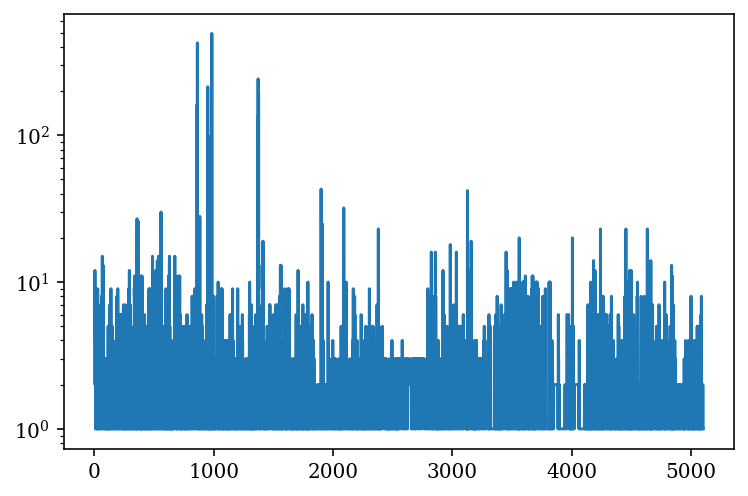

In [91]:
fig = plt.figure()
ax = fig.add_subplot(111)

sm = smelly_data.smells.map(len).reset_index(drop=True)
ax.plot(sm)

ax.set_yscale('log')

plt.show()

In [94]:
sm.mean(), sm.std(), sm.max(), sm.min()

(2.656347962382445, 11.460120377571203, 494, 1)

In [108]:
smelly_data.iloc[i].smells[0]['line']

13

# COUNTING

In [19]:
dirr = '/Users/stock/Development/cs/cs515/project/'

fs = [{'pr': 'runelite', 'repo': 'runelite'},
      {'pr': 'drools', 'repo': 'kiegroup'},
      {'pr': 'NewPipe', 'repo': 'TeamNewPipe'},
      {'pr': 'quarkus', 'repo': 'quarkusio'},
      {'pr': 'open-liberty', 'repo': 'OpenLiberty'}]

li = []
commits = 0
for f in fs:
    df = pd.read_csv(dirr + f['pr'] + '/' + f['repo'] + '-' + f['pr'] + '-commits-smells.csv',
                     index_col=None, header=0)
    commits += df['commit'].nunique()
    li.append(df)
    
print('hobbyist commits:', commits)
hobb = pd.concat(li, axis=0, ignore_index=True)


fs = [{'pr': 'skywalking', 'repo': 'apache'},
      {'pr': 'druid', 'repo': 'apache'},
      {'pr': 'flink', 'repo': 'apache'},
      {'pr': 'cassandra', 'repo': 'apache'},
      {'pr': 'beam', 'repo': 'apache'}]

li = []
commits = 0

for f in fs:
    df = pd.read_csv(dirr + f['pr'] + '/' + f['repo'] + '-' + f['pr'] + '-commits-smells.csv',
                     index_col=None, header=0)
    commits += df['commit'].nunique()
    li.append(df)
    
print('professional commits:', commits)
prof = pd.concat(li, axis=0, ignore_index=True)

hobbyist commits: 17267
professional commits: 35458


In [23]:
hobb['commit'].nunique(),hobb['email'].nunique()

(17267, 1085)

In [22]:
prof['commit'].nunique(), prof['email'].nunique()

(35458, 2033)